<a href="https://colab.research.google.com/github/thecodinguru/Walmart-Labs-Interview-Project/blob/main/walmart_sales_forecast_discount_strategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""""""""""""""""""""""
Install and I'll explain both libraries later...
"""""""""""""""""""""""
! pip install lale
! pip install lime
"""""""""""""""""""""""
Comment out both pip installs once completed
"""""""""""""""""""""""

In case you  can't wait and you are wondering what lale and lime is:

Lale: 

https://www.marktechpost.com/2020/09/30/lale-a-python-library-simplifying-automated-machine-learning/

Lime: 

https://towardsdatascience.com/decrypting-your-machine-learning-model-using-lime-5adc035109b5

# Walmart Store Sales:  

**Basic Goals:** 
* Showcase EDA skills to describe and clean the data, and to understand attributes
* Feature engineering to keep only important attributes
* Develop a framework to evaluate and spot-check algorithms
* Work on predicting and explaining future sales
* Try and identify the right time for discount strategies

You can find the dataset at:

https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting/data


**Dataset Description:**
* stores.csv

This file contains  information about the 45 stores, indicating the type and size of the store.

* train.csv

This is the historical training data, which covers from 2010-02-05 to 2012-11-01. Within this file contains:

Store - the store number  
Dept - the department number   
Date - the week 
Weekly_Sales -  sales for the given department in the given store  
IsHoliday - whether the week is a special holiday week  

* test.csv

This file is identical to train.csv, except we have withheld the weekly sales.

* features.csv

This file contains additional data related to each Walmart store, department, and regional activity for the given dates. It contains the following fields:  

Store - the store number  
Date - the week  
Temperature - the average temperature in the region  
Fuel_Price - the cost of fuel in the region  
MarkDown1-5 - data related to promotional markdowns that Walmart is running. MarkDown data is only available after Nov 2011, and is not available for all stores all the time. Any missing value I plan to mark with an NA.  
CPI - the consumer price index   
Unemployment - the unemployment rate   
IsHoliday - whether the week is a special holiday week  

# Import Needed Libraries

In [ ]:
import sys
import IPython
import pandas as pd
from pandas import set_option
set_option('display.width', 160)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
%matplotlib inline
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
py.init_notebook_mode(connected=True)
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import skew
from scipy.stats import kurtosis

# Load dataset

In [ ]:
train=pd.read_csv("https://raw.githubusercontent.com/thecodinguru/Walmart-Labs-Interview-Project/main/train.csv", parse_dates=["Date"])
test=pd.read_csv("https://raw.githubusercontent.com/thecodinguru/Walmart-Labs-Interview-Project/main/test.csv", parse_dates=["Date"])
stores=pd.read_csv("https://raw.githubusercontent.com/thecodinguru/Walmart-Labs-Interview-Project/main/stores.csv")
features = pd.read_csv("https://raw.githubusercontent.com/thecodinguru/Walmart-Labs-Interview-Project/main/features.csv", parse_dates=["Date"])
# merging store and feature attributes into one dataset with test, train
train = train.merge(stores, how='left').merge(features, how='left')
test = test.merge(stores, how='left').merge(features, how='left')

# Summarize Data

In [ ]:
train.info()
print("\n")
train.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         421570 non-null  int64         
 1   Dept          421570 non-null  int64         
 2   Date          421570 non-null  datetime64[ns]
 3   Weekly_Sales  421570 non-null  float64       
 4   IsHoliday     421570 non-null  bool          
 5   Type          421570 non-null  object        
 6   Size          421570 non-null  int64         
 7   Temperature   421570 non-null  float64       
 8   Fuel_Price    421570 non-null  float64       
 9   MarkDown1     150681 non-null  float64       
 10  MarkDown2     111248 non-null  float64       
 11  MarkDown3     137091 non-null  float64       
 12  MarkDown4     134967 non-null  float64       
 13  MarkDown5     151432 non-null  float64       
 14  CPI           421570 non-null  float64       
 15  Unemployment  421

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
1,1,1,2010-02-12,46039.49,True,A,151315,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106
2,1,1,2010-02-19,41595.55,False,A,151315,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106
3,1,1,2010-02-26,19403.54,False,A,151315,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106
4,1,1,2010-03-05,21827.90,False,A,151315,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106


In [ ]:
test.info()
print("\n")
test.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115064 entries, 0 to 115063
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         115064 non-null  int64         
 1   Dept          115064 non-null  int64         
 2   Date          115064 non-null  datetime64[ns]
 3   IsHoliday     115064 non-null  bool          
 4   Type          115064 non-null  object        
 5   Size          115064 non-null  int64         
 6   Temperature   115064 non-null  float64       
 7   Fuel_Price    115064 non-null  float64       
 8   MarkDown1     114915 non-null  float64       
 9   MarkDown2     86437 non-null   float64       
 10  MarkDown3     105235 non-null  float64       
 11  MarkDown4     102176 non-null  float64       
 12  MarkDown5     115064 non-null  float64       
 13  CPI           76902 non-null   float64       
 14  Unemployment  76902 non-null   float64       
dtypes: bool(1), datet

,Store,Dept,Date,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,1,2012-11-02,False,A,151315,55.32,3.386,6766.44,5147.70,50.82,3639.90,2737.42,223.462779,6.573
1,1,1,2012-11-09,False,A,151315,61.24,3.314,11421.32,3370.89,40.28,4646.79,6154.16,223.481307,6.573
2,1,1,2012-11-16,False,A,151315,52.92,3.252,9696.28,292.10,103.78,1133.15,6612.69,223.512911,6.573
3,1,1,2012-11-23,True,A,151315,56.23,3.211,883.59,4.17,74910.32,209.91,303.32,223.561947,6.573
4,1,1,2012-11-30,False,A,151315,52.34,3.207,2460.03,NaN,3838.35,150.57,6966.34,223.610984,6.573


After running the cell, we can see that the test dataset do not contain the features included in the train dataset, taking into consideration that these features (Temperature, Fuel price, MarkDowns, CPI and Unemployment) cannot be used in the test dataset due to their high dependences on the date, so it will be a good idea to delete them when we begin feature engineering. but before that, we will make sure that these features don't provide any information on the target column 'Weekly_Sales'. 

In [ ]:
# Checking for null values
train.isnull().mean()*100

Store            0.000000
Dept             0.000000
Date             0.000000
Weekly_Sales     0.000000
IsHoliday        0.000000
Type             0.000000
Size             0.000000
Temperature      0.000000
Fuel_Price       0.000000
MarkDown1       64.257181
MarkDown2       73.611025
MarkDown3       67.480845
MarkDown4       67.984676
MarkDown5       64.079038
CPI              0.000000
Unemployment     0.000000
dtype: float64

The MarkDowns attributes have more than 64% of null values, in addition, the lack of understanding what MarkDowns exactly mean, it makes it difficult to fill the columns with appropriate values. 
Let's check their correlations with the target 'Weekly_Sales' and see if we can get rid of it.

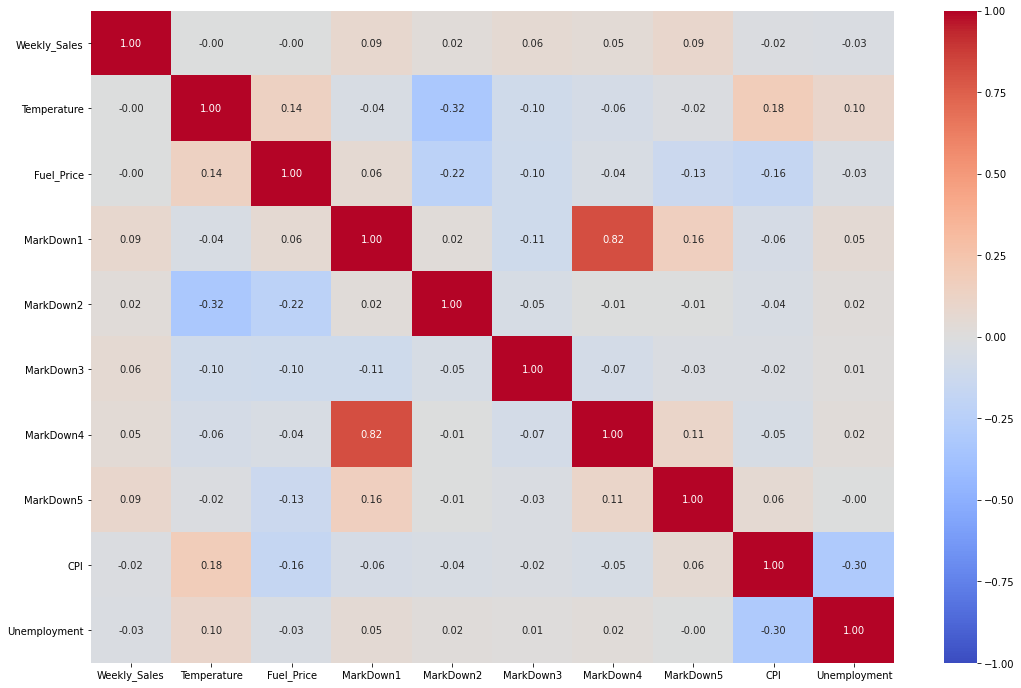

In [ ]:
corr = train[['Weekly_Sales','Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2',
                 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment']].corr()
fig, ax = plt.subplots(figsize=(18, 12))
ax = sns.heatmap(corr , vmin=-1, vmax=1, annot=True, fmt='.2f', cmap='coolwarm')
plt.show()

In [ ]:
abs(corr["Weekly_Sales"])

Weekly_Sales    1.000000
Temperature     0.002312
Fuel_Price      0.000120
MarkDown1       0.085251
MarkDown2       0.024130
MarkDown3       0.060385
MarkDown4       0.045414
MarkDown5       0.090362
CPI             0.020921
Unemployment    0.025864
Name: Weekly_Sales, dtype: float64

As we can see, correlations of the features above with the target 'WeeklySales' are approximately 0. So it's safe to delete them.

In [ ]:
train = train.drop(['Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2',
                    'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment'], axis = 1)
test = test.drop(['Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2',
                    'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment'], axis = 1)
train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size
0,1,1,2010-02-05,24924.50,False,A,151315
1,1,1,2010-02-12,46039.49,True,A,151315
2,1,1,2010-02-19,41595.55,False,A,151315
3,1,1,2010-02-26,19403.54,False,A,151315
4,1,1,2010-03-05,21827.90,False,A,151315


Another useful step I like to do is to deconstruct the 'Date' column by splitting it into its componenents (in this case, Year and week).

In [ ]:
train['week']=train['Date'].dt.week
train['year']=train['Date'].dt.year
test['week']=test['Date'].dt.week
test['year']=test['Date'].dt.year
del test['Date']
del train['Date']
train.head()

,Store,Dept,Weekly_Sales,IsHoliday,Type,Size,week,year
0,1,1,24924.50,False,A,151315,5,2010
1,1,1,46039.49,True,A,151315,6,2010
2,1,1,41595.55,False,A,151315,7,2010
3,1,1,19403.54,False,A,151315,8,2010
4,1,1,21827.90,False,A,151315,9,2010


In [ ]:
# Let's count and see the distinct value of Type :  
print(train[['Type', 'IsHoliday']].nunique())
Types = train['Type'].unique()
Holi = train['IsHoliday'].unique()
print(f'The 3 types of Store : {Types}')
print(f'The Holiday Flag : {Holi}')

Type         3
IsHoliday    2
dtype: int64
The 3 types of Store : ['A' 'B' 'C']
The Holiday Flag : [False  True]


Being a Linear problem, last step is to LabelEncode the categorigal attributes, namely, Type and IsHoliday:

In [ ]:
from sklearn.preprocessing import LabelEncoder

train['Type']=LabelEncoder().fit_transform(train['Type'])
train['IsHoliday']=LabelEncoder().fit_transform(train['IsHoliday'])
Types = train['Type'].unique()
Holi = train['IsHoliday'].unique()
print(f'The new 3 types of Store : {Types}')
print(f'The Holiday Flag : {Holi}')

# Test set
test['IsHoliday']=LabelEncoder().fit_transform(test['IsHoliday'])
test['Type']=LabelEncoder().fit_transform(test['Type'])

The new 3 types of Store : [0 1 2]
The Holiday Flag : [0 1]


Now we proceed to analyse each attribute.

# Quick Glance: Weekly Sales

In [ ]:
# Weekly_Sales statistics:
train['Weekly_Sales'].describe()

count    421570.000000
mean      15981.258123
std       22711.183519
min       -4988.940000
25%        2079.650000
50%        7612.030000
75%       20205.852500
max      693099.360000
Name: Weekly_Sales, dtype: float64

Weekly Sales mean is much higher than the median (50%), which make its distribution skewed to the right.

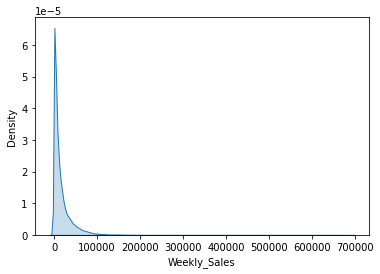

Weekly_Sales: mean (15981.258123), variance (515796633.324593), skewness (3.261997), kurtosis (21.491021)


In [ ]:
sns.kdeplot(train['Weekly_Sales'], shade=True);
plt.show()
print("%s: mean (%f), variance (%f), skewness (%f), kurtosis (%f)" 
      % ('Weekly_Sales', np.mean(train['Weekly_Sales']), np.var(train['Weekly_Sales']),
         skew(train['Weekly_Sales']), kurtosis(train['Weekly_Sales'])))

The plot makes the right skewness clear, so most weeks have sales around the median.  
Also, we can see that the Weekly_Sales attribute has a large kurtosis which indicates the presence of extreme values, in other words, some weeks have high sales. It would be a good idea to get a better understanding of these extreme values. 

We can have some idea on attributes contributing to the target Weekly_Sales, by calculating correlations : 

In [ ]:
# Weekly_Sales Correlations:
cor_Sales = abs(train.corr()['Weekly_Sales']).sort_values(ascending=False)
print(cor_Sales, '\n')

Weekly_Sales    1.000000
Size            0.243828
Type            0.182242
Dept            0.148032
Store           0.085195
week            0.027673
IsHoliday       0.012774
year            0.010111
Name: Weekly_Sales, dtype: float64 



* At first glance, the characteristics of the store (Type, Size and Departments) appear to correlate the most with the target.

# Type Correlation

In [ ]:
# Type Correlations:
cor_Type = abs(train.corr()['Type']).sort_values(ascending=False)
print(cor_Type, '\n')

Type            1.000000
Size            0.811593
Store           0.226410
Weekly_Sales    0.182242
year            0.004208
Dept            0.003708
IsHoliday       0.000798
week            0.000003
Name: Type, dtype: float64 



Let's investigate the relation beetwen the store Type and other attributes.

In [ ]:
def xyBox(X,Y,showfliers=True, hue=None, figsize=(9, 6)) :
    f, ax = plt.subplots(figsize=figsize)
    fig = sns.boxplot(x=X, y=Y, data=train, showfliers=showfliers,hue=hue, showmeans=True, meanline=True, meanprops = dict(linestyle='--', linewidth=2.5, color='red'))
    fig.text(-1.5, 0, 'mean : ---', color='red', weight='roman',size=14)

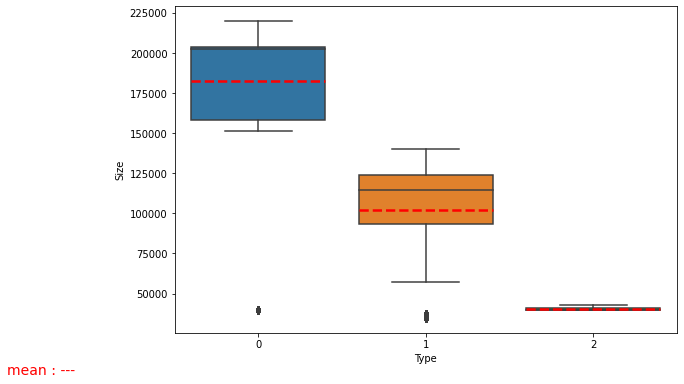

In [ ]:
xyBox('Type', 'Size')

By neglecting the outliers, we can say that the store Type determines the size of it, Type 0 has the highest size and Type 2 has the lowest.  
-> The two attributes are highly correlated (~0.81)

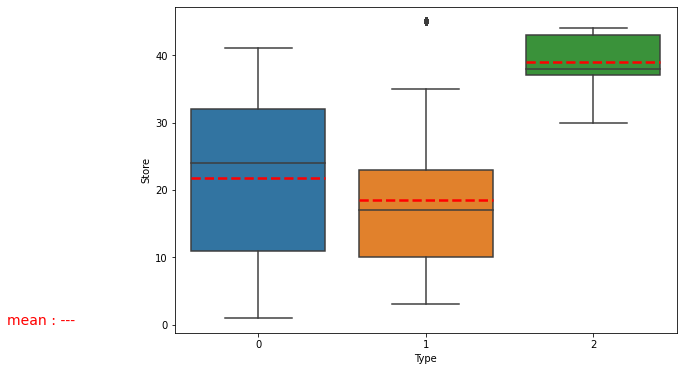

In [ ]:
xyBox('Type', 'Store')

Type 0 includes a large range of possible stores, which overlaps with other Types. As a result, we have a moderate correlation (~0.22) between Type and Store.  

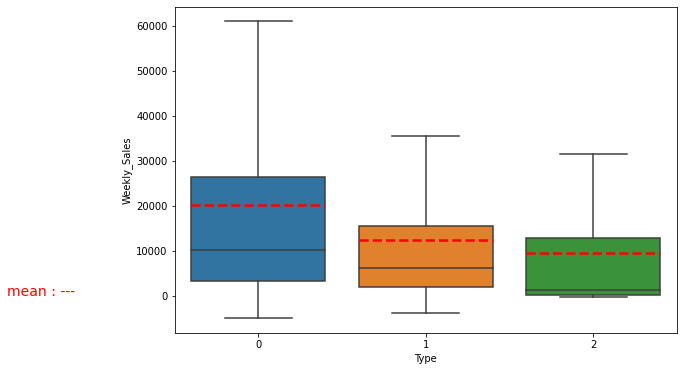

In [ ]:
xyBox('Type', 'Weekly_Sales',showfliers=False)

We can see that store Type 0 has the highest median (mean) in terms of weekly sales, and Type 2 has the lowest.

**Conclusion:**
* The store Type may provide information on the target.  
* The store Type gives implicit information on the size of the store.

# Size Correlation

In [ ]:
# Size Correlations:
cor_Size = abs(train.corr()['Size']).sort_values(ascending=False)
print(cor_Size, '\n')

Size            1.000000
Type            0.811593
Weekly_Sales    0.243828
Store           0.182881
year            0.004975
Dept            0.002966
week            0.001292
IsHoliday       0.000593
Name: Size, dtype: float64 



In [ ]:
# Size statistics:
train['Size'].describe()

count    421570.000000
mean     136727.915739
std       60980.583328
min       34875.000000
25%       93638.000000
50%      140167.000000
75%      202505.000000
max      219622.000000
Name: Size, dtype: float64

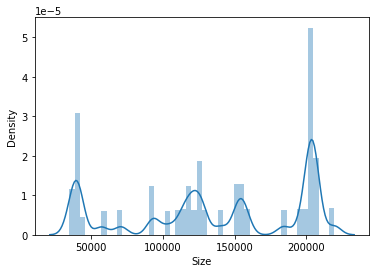

In [ ]:
# Size distribution :
sns.distplot(train['Size']);
plt.show()

The size has a balanced distribution (mean ~ median), and a large range.

Roughly speaking, the store Size distribution has 3 "peaks", which can be attributed to the store Type as seen earlier.  

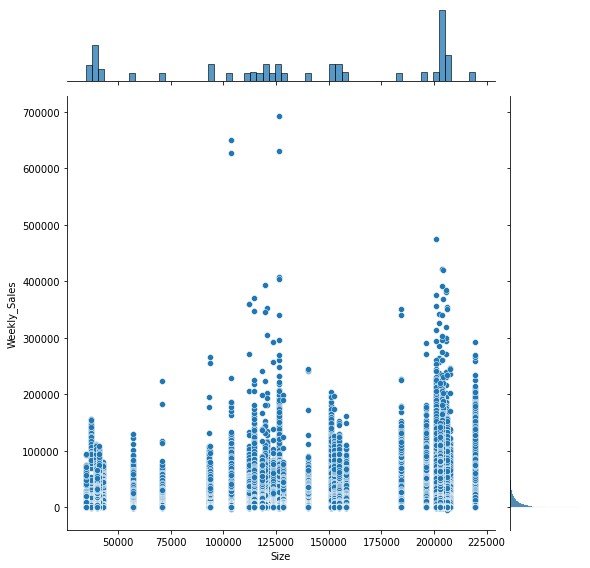

In [ ]:
# Size relation with Weekly_Sales
sns.jointplot(x='Size', y='Weekly_Sales', data=train, height=8)
plt.show()

We can see that there is some high sale values as the size increases, which corresponds to the moderate correlation between the Size and Weekly_Sales.

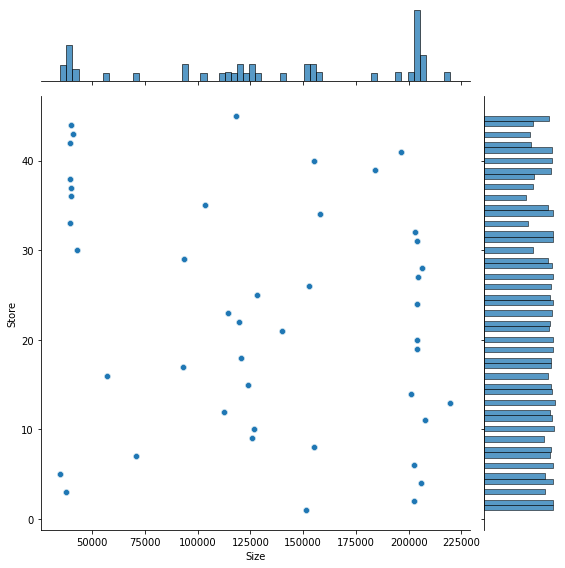

In [ ]:
# Size relation with Store
sns.jointplot(x='Size', y='Store', data=train, height=8)
plt.show()

We can't recognize any pattern between the Size and Stores, which explains the poor correlation of ~0.18.

**Conclusion:**
* The Size may provide information on the target.  
* The Size is not correlated with any other attributes, except the Type.

# Store Correlation

In [ ]:
# Store Correlations:
cor_Store = abs(train.corr()['Store']).sort_values(ascending=False)
print(cor_Store, '\n')

Store           1.000000
Type            0.226410
Size            0.182881
Weekly_Sales    0.085195
Dept            0.024004
year            0.002997
week            0.001031
IsHoliday       0.000548
Name: Store, dtype: float64 



There is only small correlations between Store and Type, Size.

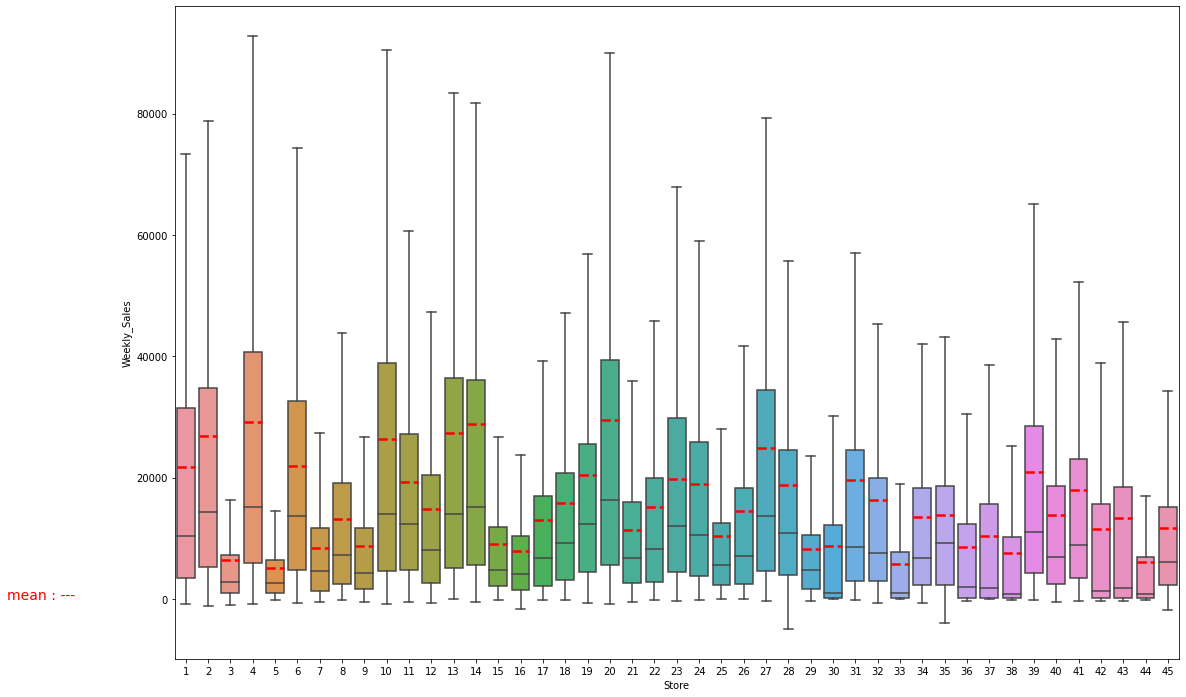

In [ ]:
fig, ax = plt.subplots(figsize=(18, 12))
fig = sns.boxplot(x='Store', y='Weekly_Sales', data=train, showfliers=False, showmeans=True, meanline=True, meanprops = dict(linestyle='--', linewidth=2.5, color='red'))
fig.text(-8, 0, 'mean : ---', color='red', weight='roman',size=14)
plt.show()

Sales are different for each store, so they may depend on the store.

**Conclusion:**
* The Store may provide some information on Sales.

# Dept Correlation

In [ ]:
# Dept Correlations:
cor_Dept = abs(train.corr()['Dept']).sort_values(ascending=False)
print(cor_Dept, '\n')

Dept            1.000000
Weekly_Sales    0.148032
Store           0.024004
year            0.003738
Type            0.003708
Size            0.002966
IsHoliday       0.000916
week            0.000882
Name: Dept, dtype: float64 



The Dept column is moderately correlated with Weekly_Sales.

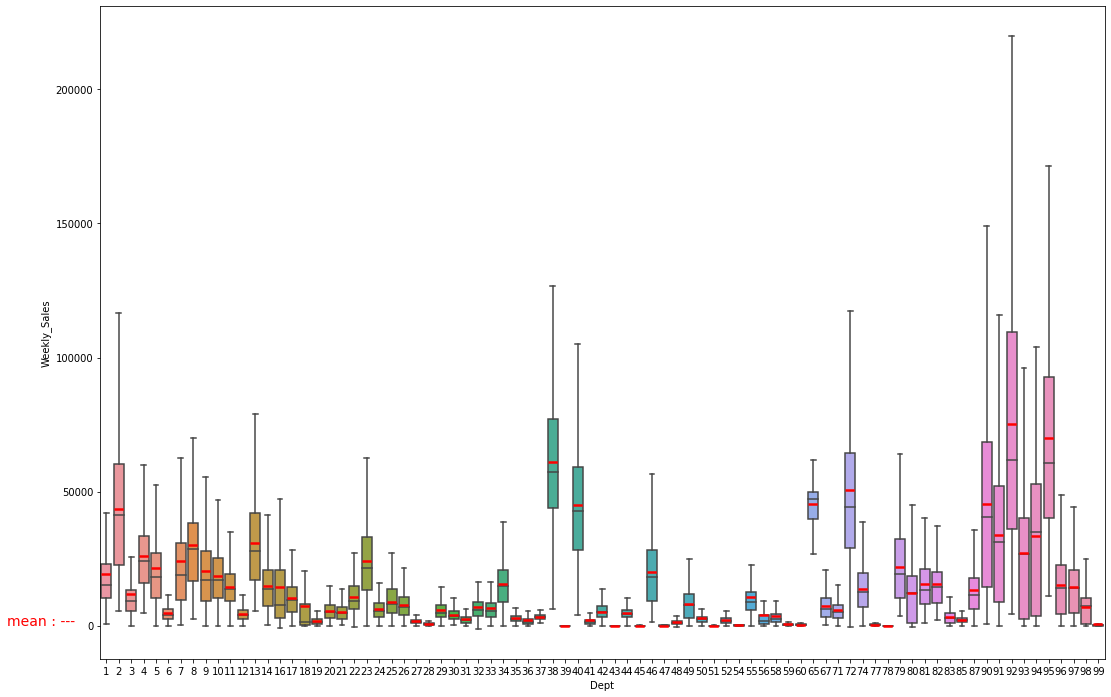

In [ ]:
# Dept relation with Weekly_Sales
fig, ax = plt.subplots(figsize=(18, 12))
fig = sns.boxplot(x='Dept', y='Weekly_Sales', data=train, showfliers=False, showmeans=True, meanline=True, meanprops = dict(linestyle='--', linewidth=2.5, color='red'))
fig.text(-8, 0, 'mean : ---', color='red', weight='roman',size=14)
plt.show()

The Departements show distinct range of Sales, which may tell something about them.

**Conclusion:**  
* Each Departement may contain some information on the target. 

# Week Correlation

In [ ]:
# Week Correlations:
cor_week = abs(train.corr()['week']).sort_values(ascending=False)
print(cor_week, '\n')

week            1.000000
year            0.181797
IsHoliday       0.128184
Weekly_Sales    0.027673
Size            0.001292
Store           0.001031
Dept            0.000882
Type            0.000003
Name: week, dtype: float64 



There is no correlation between the week and Sales.

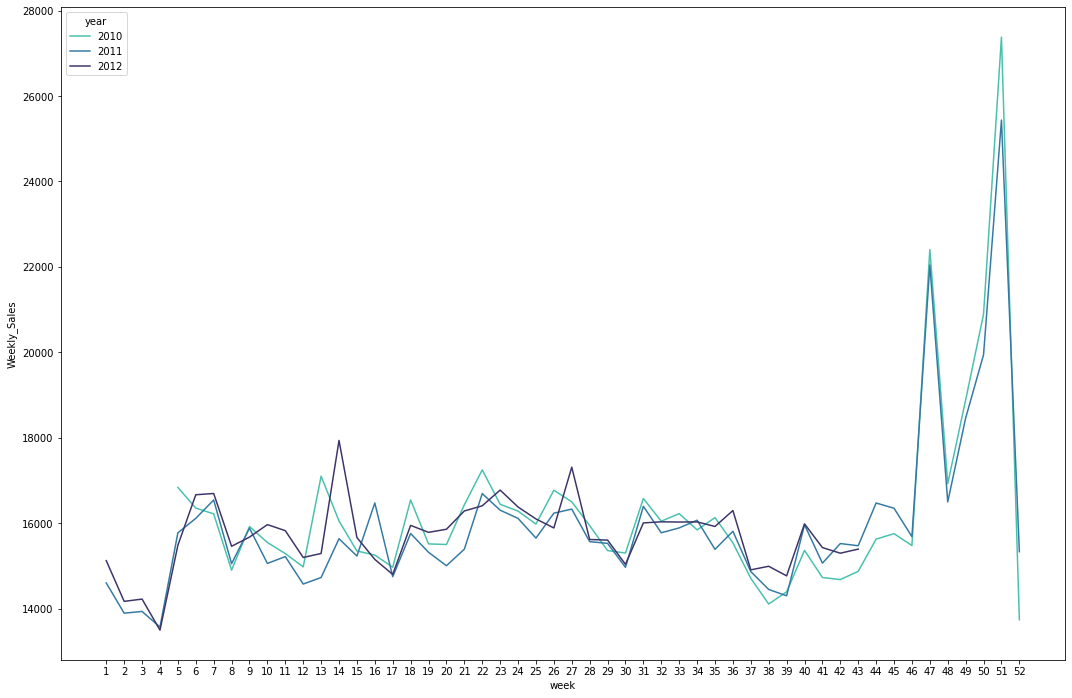

In [ ]:
# Distribution of sales over weeks:
fig, ax = plt.subplots(figsize=(18, 12))
palette = sns.color_palette("mako_r", 3)
fig = sns.lineplot(x='week', y='Weekly_Sales', data=train, hue='year', err_style=None, palette=palette)
plt.xticks(np.arange(1, 53, step=1))
plt.show()

The distribution of Sales over weeks is not impacted by the year, so it safe to assume the year is irrelevant to this situation.  

The Holidays by week:    
Week 6  : Super Bowl  
Week 36 : Labor Day  
Week 47 : Thanksgiving  
Week 52 : Christmas   



This explains peaks in Sales at these weeks. However there is a subtlety concerning the Christmas, the peak in Sales happens at the Week 51, one week before the Christmas week, this can be explained by the fact that people prepare for the Christmas days before, so shifting the Holiday sale for Christmas to Week 51 will be a good choice.

**Conclusion:**
* Week doesn't tell much about Sales, except for weeks marked as HoliDays.

# HoliDays Correlation

Let's visualize the impact of Holidays on Sales:

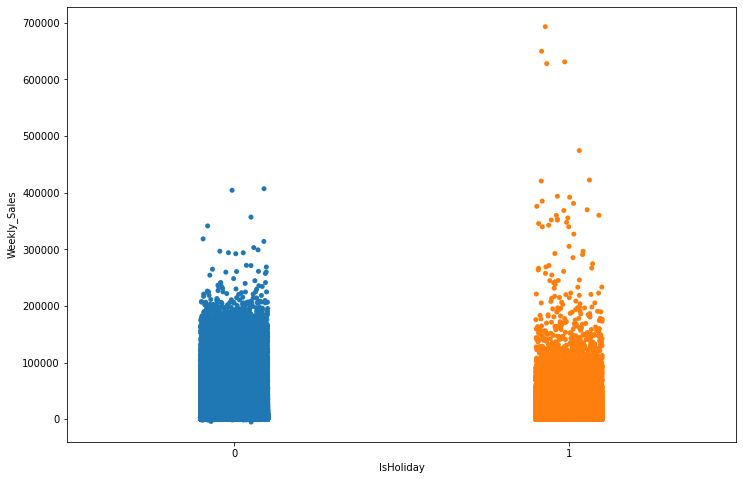

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
fig = sns.stripplot(x='IsHoliday', y='Weekly_Sales', data=train)
plt.show()

As expected, Holiday Sales have some high values.

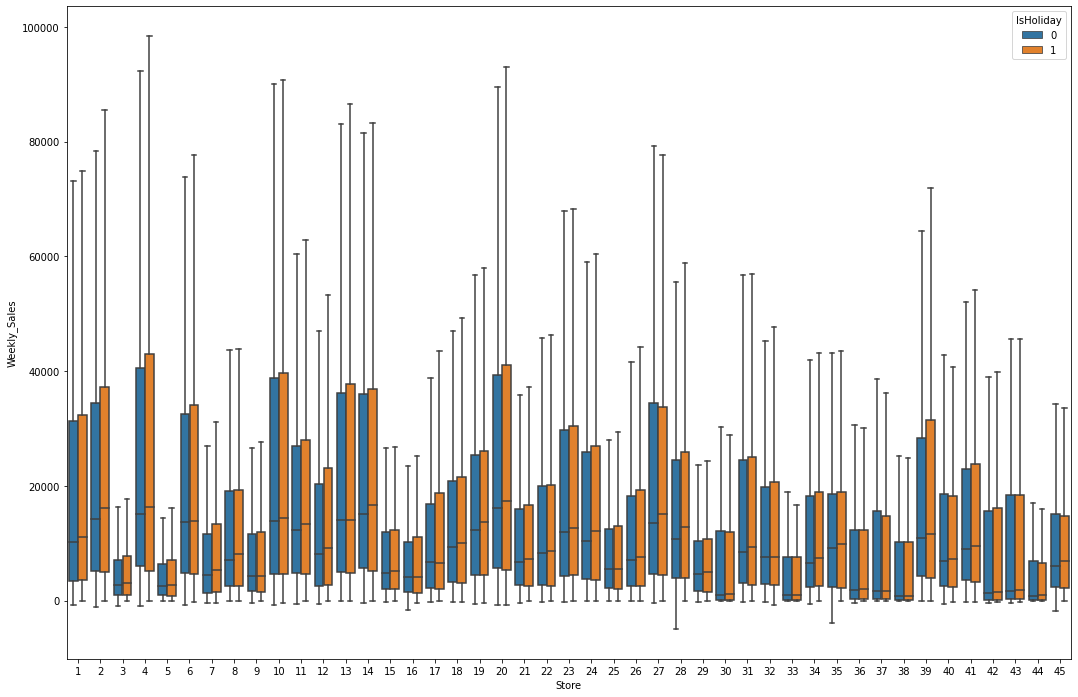

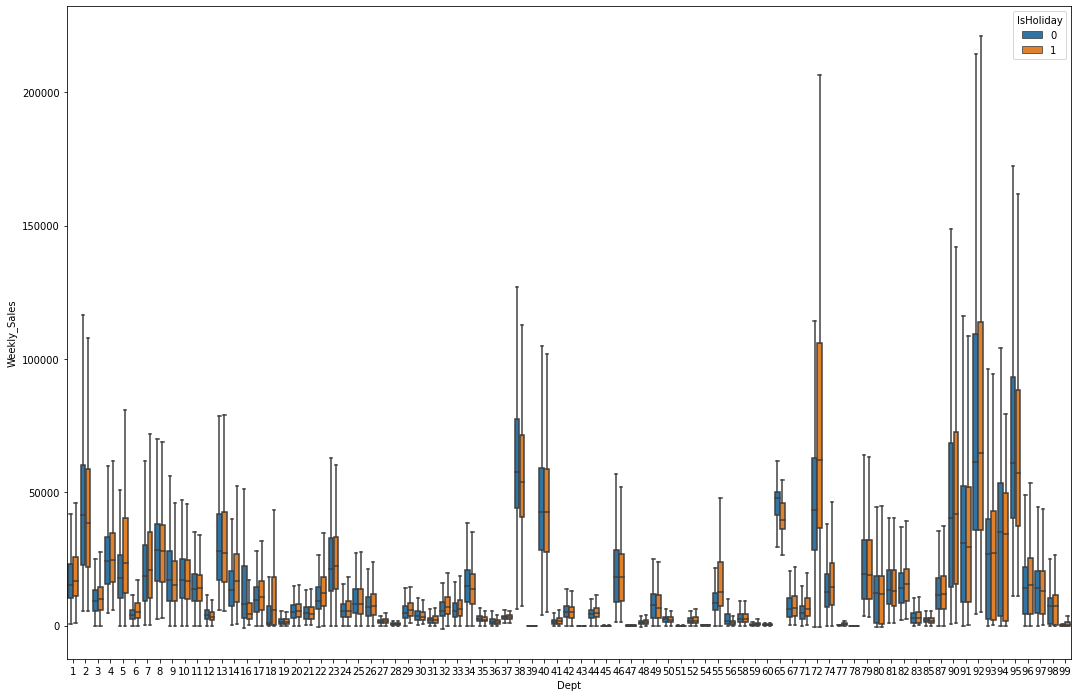

In [ ]:
# Weekly Sales per Dept with the Holiday Flag:
fig, ax = plt.subplots(figsize=(18, 12))
fig = sns.boxplot(x='Store', y='Weekly_Sales', data=train, hue='IsHoliday', showfliers=False)
# Weekly Sales per Store with the Holiday Flag:
fig, ax = plt.subplots(figsize=(18, 12))
fig = sns.boxplot(x='Dept', y='Weekly_Sales', data=train, hue='IsHoliday', showfliers=False)

In general, Sales in Stores and Department increase slightly during Holidays, except for some small number of Departments, for instance, Weekly Sales median of Dept 38 decreases due to low sales during Holidays, which i attritube to maybe the nature of products in these Departments.  

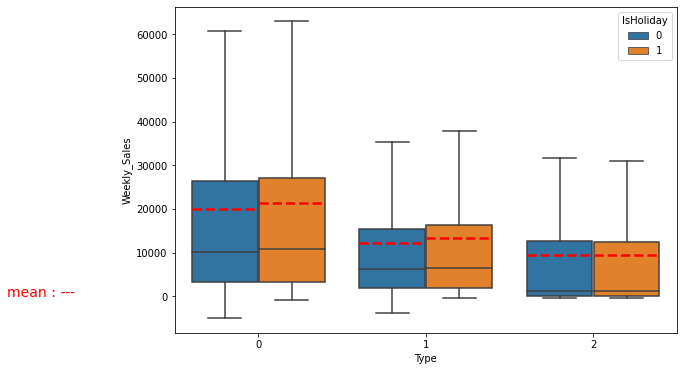

In [ ]:
# Weekly Sales per store Type with the Holiday Flag:
xyBox('Type','Weekly_Sales', hue='IsHoliday', showfliers=False)

**Conclusion:**
* Sales increase at Holidays.

# Feature Selection

After analyzing and knowing the data, it's time to keep only important features, because irrelevant or redundant features impact negatively the speed, accuracy of algorithms and could potentially cause overfitting problems.

Moreover, reducing features enable the algorithm to train faster and make the model easier to interpret.

In [ ]:
# Attributes:
train.columns

Index(['Store', 'Dept', 'Weekly_Sales', 'IsHoliday', 'Type', 'Size', 'week', 'year'], dtype='object')

Let's check features importance using the random forest algorithm.

In [ ]:
# Separating the target from data:
X = train.drop('Weekly_Sales',axis=1)
y_train = train['Weekly_Sales']

# importing the random forest algorithm
from sklearn.ensemble import RandomForestRegressor
# fitting the model
rf = RandomForestRegressor()
rf.fit(X,y_train)
# Feature importance:
pd.DataFrame({'Features':X.columns,'Relative Importance':rf.feature_importances_}).sort_values(by='Relative Importance', ascending=False)

,Features,Relative Importance
1,Dept,0.630657
4,Size,0.207639
0,Store,0.073319
5,week,0.064365
3,Type,0.014645
6,year,0.007082
2,IsHoliday,0.002293


As we can see, the most important feature is Dept, followed by Size.

And as seen before, Type and Size are highly correlated and contain the same information, so in this case I am deciding to keep 'Size'.

And for safe measure, 'year' is irrelevant and don't contain any information on the target -> I will drop it from the data.

In [ ]:
X_train = X.drop(['Type', 'year'],axis=1)

# Evaluate Algorithms

After analyzing, cleaning and preparing the data, the next step is to select the best algorithm with optimal parameters to obtain the best results.

This step requires manually selecting the type of data normalization, then manually selecting algorithms and tune all hyperparameters, which can be a complex task to do. 

Instead, I will use AutoML, which is a series of concepts and techniques used to automate these processes and help reducing bias and errors.

AutoML can be done using the Lale library, a powerful tool which serves for hyperparameter tuning and algorithm selection. 

Many algorithms assume normal distribution of the data, especially when features have different ranges like ours, so it is necessary to implement this step in our pipeline.  

For data normalization, Lale will have the following choices :  

* MinMaxscaler: scaling data values in the range [0,1]
* StandardScaler: data distribution will have a mean = 0 and std =1
* PCA: for linear dimensionality reduction
* NoOp: keep the data unchanged  

Algorithms used for spot-checking :  

* LinearRegression
* RandomForestRegressor
* GradientBoostingRegressor
* ExtraTreesRegressor
* KNeighborsRegressor
* SVR


In [ ]:
import lale
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer
from lale.lib.lale import Hyperopt, NoOp, GridSearchCV
from lale.pretty_print import ipython_display
import lale.schemas as schemas
import lale.helpers
lale.wrap_imported_operators()

For hyperparameter tuning, Lale give us the choice to use its search space or schemas as is, OR we can customize the schemas to fit our purposes (which helps reduce the search space to speed up the overall search time).

In [ ]:
# RandomForestRegressor hyperparameter to costumize:
print( 'RandomForestRegressor:\n')
ipython_display(RandomForestRegressor.hyperparam_schema('n_estimators'))
ipython_display(RandomForestRegressor.hyperparam_schema('min_samples_leaf'))
# ExtraTreesRegressor hyperparameter to costumize:
print( 'ExtraTreesRegressor:\n')
ipython_display(ExtraTreesRegressor.hyperparam_schema('n_estimators'))
ipython_display(ExtraTreesRegressor.hyperparam_schema('min_samples_leaf'))
# GradientBoostingRegressor hyperparameter to costumize:
print( 'GradientBoostingRegressor:\n')
ipython_display(GradientBoostingRegressor.hyperparam_schema('n_estimators'))
ipython_display(GradientBoostingRegressor.hyperparam_schema('min_samples_leaf'))

RandomForestRegressor:



```python
{
    "default": 100,
    "description": "The number of trees in the forest.",
    "type": "integer",
    "minimumForOptimizer": 10,
    "maximumForOptimizer": 100,
}
```

```python
{
    "anyOf": [
        {
            "type": "integer",
            "minimum": 1,
            "forOptimizer": false,
            "description": "Consider min_samples_leaf as the minimum number.",
        },
        {
            "type": "number",
            "minimum": 0.0,
            "exclusiveMinimum": true,
            "minimumForOptimizer": 0.01,
            "maximum": 0.5,
            "default": 0.05,
            "description": "min_samples_leaf is a fraction and ceil(min_samples_leaf * n_samples) are the minimum number of samples for each node.",
        },
    ],
    "default": 1,
    "description": "The minimum number of samples required to be at a leaf node.",
}
```

ExtraTreesRegressor:



```python
{
    "default": 100,
    "description": "The number of trees in the forest.",
    "type": "integer",
    "minimumForOptimizer": 10,
    "maximumForOptimizer": 100,
}
```

```python
{
    "anyOf": [
        {
            "type": "integer",
            "minimumForOptimizer": 1,
            "maximumForOptimizer": 20,
            "distribution": "uniform",
        },
        {
            "type": "number",
            "minimumForOptimizer": 0.01,
            "maximumForOptimizer": 0.5,
            "default": 0.05,
        },
    ],
    "default": 1,
    "description": "The minimum number of samples required to be at a leaf node.",
}
```

GradientBoostingRegressor:



```python
{
    "type": "integer",
    "minimumForOptimizer": 10,
    "maximumForOptimizer": 100,
    "distribution": "uniform",
    "default": 100,
    "description": "The number of boosting stages to perform. Gradient boosting",
}
```

```python
{
    "anyOf": [
        {
            "type": "integer",
            "minimumForOptimizer": 1,
            "maximumForOptimizer": 20,
            "distribution": "uniform",
        },
        {
            "type": "number",
            "minimumForOptimizer": 0.01,
            "maximumForOptimizer": 0.5,
            "default": 0.05,
        },
    ],
    "default": 1,
    "description": "The minimum number of samples required to be at a leaf node.",
}
```

As you can see, the search space for the number of trees in the forest is in the range of [10, 100] and for min_samples_leaf: [1, 20].  

For all algorithms, I will reduce them to [10, 20] and [1, 5] respectively. 

In [ ]:
RandomForestRegressor = RandomForestRegressor.customize_schema(n_estimators=schemas.Int(min=10, max=20),
                                                               min_samples_leaf=schemas.Int(min=1, max=5))

ExtraTreesRegressor = ExtraTreesRegressor.customize_schema(n_estimators=schemas.Int(min=10, max=20),
                                                           min_samples_leaf=schemas.Int(min=1, max=5))

GradientBoostingRegressor = GradientBoostingRegressor.customize_schema(n_estimators=schemas.Int(min=10, max=20),
                                                                       min_samples_leaf=schemas.Int(min=1, max=5))                                                           

Now I will create the pipeline and visualize it with Lale.

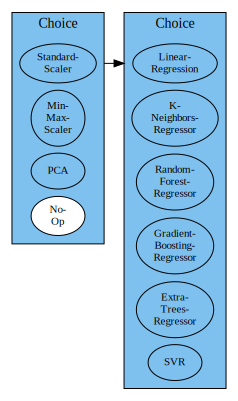

In [ ]:
pipeline = (StandardScaler | MinMaxScaler | PCA | NoOp)  >>  (LinearRegression | KNeighborsRegressor |
               RandomForestRegressor | GradientBoostingRegressor | ExtraTreesRegressor  | SVR )
pipeline.visualize()

We choose the negative mean absolute error metric (which is easier to understand and to interpret) to define the loss function, and let Hyperopt determine the optimal pipeline that minimize the loss.

In [ ]:
scoring = 'neg_mean_absolute_error'
pip_selection =  Hyperopt(estimator = pipeline, cv = 3, max_evals = 20, scoring=scoring, max_eval_time=120)

In [ ]:
#This may take some time...
pip_trained = pip_selection.fit(X_train, y_train)

100%|██████████| 20/20 [05:24<00:00, 16.24s/trial, best loss: 6063.389805210011]
2 out of 20 trials failed, call summary() for details.
Run with verbose=True to see per-trial exceptions.


After that is finished, let's visualize the best pipeline with optimal parameters:

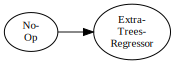

```python
extra_trees_regressor = ExtraTreesRegressor(
    min_samples_leaf=3, min_samples_split=14, n_estimators=15
)
pipeline = NoOp() >> extra_trees_regressor
```

In [ ]:
pip_trained.get_pipeline().visualize()
pip_trained.get_pipeline().pretty_print(ipython_display= True, show_imports= False)

The best pipeline don't use any data normalization, which is easy to understand since the selected ExtraTreesRegressor algorithm is not affected by any data transformation.

In [ ]:
# Summary of all pipelines:
pip_trained.summary()

,tid,loss,time,log_loss,status
name,,,,,
p0,0,12851.601641,1.014907,NaN,ok
p1,1,20644.109174,1.332602,NaN,ok
p2,2,14347.747392,0.190050,NaN,ok
p3,3,14347.747392,0.245012,NaN,ok
p4,4,NaN,NaN,NaN,fail
p5,5,NaN,NaN,NaN,fail
p6,6,13818.355482,0.548094,NaN,ok
p7,7,12490.583756,2.926019,NaN,ok
p8,8,14334.780788,0.232463,NaN,ok


In [ ]:
best = pip_trained.summary().loss.argmin()
loss_b = pip_trained.summary().loss.min()
worst = pip_trained.summary().loss.argmax()
loss_w = pip_trained.summary().loss.max()
print(f'The best pipeline is {best} with a loss of {loss_b}')
print(f'The worst pipeline is {worst} with a loss of {loss_w}')

The best pipeline is 11 with a loss of 6063.389805210011
The worst pipeline is 1 with a loss of 20644.109173634522


# Final Model & Predictions

Now, I will train the model on the entire training dataset using the ExtraTreesRegressor model with optimal parameters:

In [ ]:
extra_trees_regressor = ExtraTreesRegressor(min_samples_leaf=3, min_samples_split=14, n_estimators=15)
extra_trees_regressor.fit(X_train, y_train)

In [ ]:
X_test = test.drop(['Type', 'year'], axis=1)

Make and evaluate predictions:

In [ ]:
predictions = extra_trees_regressor.predict(X_test)

After making predictions, the most common question I ask myself is; can I trust certain predictions and take actions based on them?

The help eliminate my doubt, I will use  LIME and its techniques to explain some predictions.

Firstly, we define the explainer provided by LIME

In [ ]:
import lime
import lime.lime_tabular
# Define the explainer:
X_train_arr = X_train.to_numpy()
explainer = lime.lime_tabular.LimeTabularExplainer(X_train_arr, feature_names=X_train.columns, 
            class_names=['Weekly_Sales'], verbose=False, mode='regression',
            categorical_features=['IsHoliday'], discretizer='decile', random_state=5)

Now we select 2 instances, the first isn't a Holiday week, the second is, and we show explanations.

In [ ]:
X_test_arr = X_test.to_numpy()
i = 1
exp = explainer.explain_instance(X_test_arr[i], extra_trees_regressor.predict, num_features=5)
exp.show_in_notebook(labels=None, predict_proba=True, show_predicted_value=True)
print(f'Document id: {i}')
print('Weekly Sales prediction:', extra_trees_regressor.predict(X_test_arr)[i])
print ('Explanation for prediction:')
print ('\n'.join(map(str, exp.as_list())))

In [ ]:
i = 10055
exp = explainer.explain_instance(X_test_arr[i], extra_trees_regressor.predict, num_features=5)
exp.show_in_notebook(labels=None, predict_proba=True, show_predicted_value=True)
print(f'Document id: {i}')
print('Weekly Sales prediction:', extra_trees_regressor.predict(X_test_arr)[i])
print ('Explanation for prediction:')
print ('\n'.join(map(str, exp.as_list())))

We can see how each attribute contributes to the prediction, either positively or negatively.

The Holiday Flag is 0 in the first instance, which negatively affects predicted Sales and Dept 1 has relatively high Sales which positively impacts predicted Sales.

Otherwise, the large size of the second example contributes significantly to predicted Sales, in contrast to Dept 67, with relatively low Sales, negatively affects predicted Sales.

-> I can say after studying it further, these predictions are trustworthy.

But can we say now that we trust the model to exploit it in real life?...

To see if we can trust the model, a global explanation of it is required. So we will select a representative and non-redundant set of explanations that provide a global perspective on the model.

I will do this by using SP-LIME, which is an extension of LIME.


In [ ]:
# Code for SP-LIME
import warnings
from lime import submodular_pick

sp_obj = submodular_pick.SubmodularPick(explainer, X_test_arr, extra_trees_regressor.predict, num_features=5,num_exps_desired=8)

[exp.show_in_notebook() for exp in sp_obj.sp_explanations]

After analyzing these explanations we can say that they are trustworthy and the model can be trusted as well. 

Now that we have assumed the predictions are trustworthy, I will suggest some actions to take based on these predictions.  

I will plot Weekly Sales over number of weeks, knowing that predictions begin at Week 44, 2012 and end at Week 30, 2013.

In [ ]:
# test data
predictions = pd.DataFrame(predictions, columns=['Weekly_Sales'])
test_ = pd.concat([test.drop('Type', axis=1),predictions],axis=1)
# training data
WS_train = pd.DataFrame(train.Weekly_Sales, columns=['Weekly_Sales'])
train_ = pd.concat([X.drop('Type', axis=1),WS_train],axis=1)
# data
data = pd.concat([test_,train_])

In [ ]:
# Distribution of sales over weeks:
fig, ax = plt.subplots(figsize=(18, 12))
palette = sns.color_palette("mako_r", 4)
fig = sns.lineplot(x='week', y='Weekly_Sales', data = data, hue='year', err_style=None, palette=palette)
plt.xticks(np.arange(1, 53, step=1))
plt.show()

##Final Analysis & Discount Suggestions

As you can see, the plot of predicted Sales has the same signature as the original Sales.  
The model predicts low Sales right after Easter Day, starting from Week 14, for that reason planning bundled and volume discounts during these Weeks may improve Sales. 

The same goes for Weeks before Thanksgiving Holiday.  Moreover, event discounts in some Weeks' Holiday wich have relatively low sales (SuperBowl, Easter Day, Memorial Day, Independence Day and Labor Day) compared to other Weeks' Holiday (Thanksgiving or Christmas), may potentially enhance Sales.  